In [2]:
import numpy as np
import qnm
import bilby
import matplotlib.pyplot as plt

In [3]:
def shift_model(time, ts, tau, tau_q, fo, f_q, phi, phi_q, A, Aq, t0, **kwargs):
    
    """ 
    
    quantum shift (not fractional)
    
    
    """
    
    plus = np.zeros(len(time))
    cross = np.zeros(len(time))
    
    tidxg = time >= t0
    tidxq = time >= ts
    
    GR_part = A*np.exp(-(time[tidxg]-t0)/tau)*np.exp(1j*((time[tidxg]-t0)*2*np.pi*fo) + phi)
    
    
    plus[tidxg] += GR_part.real 
    
    plus[tidxq] += Q_part.real
    
    return {'plus': plus, 'cross': cross}

In [21]:
def frac_shift_1(time, frac_dw, frac_dtau, dphi, A, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: 1 Q mode 
    
    frac_dw, frac_dtau are defined as dw/w (or dtau/tau)
    ts is Q mode start time, phi is phase, w is angular freq., tau is damping time (assumed negative)
        
    outputs plus and cross polarizations as dictionary
    
    get Q values from create_bru_dict function
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    
    amplitude = A
    omegar_term = w * (1+frac_dw)
    time_term_q = (time[tidq] - ts)
    phi_term = phi + dphi
    tau_term = tau * (1+frac_dtau)
    
    wave[tidq] = amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    
    
    return {'plus': wave.real, 'cross': wave.imag}

In [5]:
def frac_shift_2(time, frac_dw, frac_dtau, dphi, A, t0, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: superposition of 1 GR mode and 1 Q mode 
    
    get Q values from create_bru_dict function 
    
    get GR values from qnm package
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    tidg = time >= t0
    
    amplitude = A 
    omegar_term = w * (1+frac_dw)
    time_term_q = (time[tidq] - ts)
    time_term_g = (time[tidg] - t0)
    phi_term = phi + dphi
    tau_term = tau * (1+frac_dtau)
    
    wave[tidq] += amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    wave[tidg] += amplitude * np.exp(1j*(w*time_term_g)) * np.exp(1j*(phi)) * np.exp(time_term_g/(tau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [6]:
def create_bru_values(m_odd, em, M, a, n_ref, A):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns dictionary: amplitude (quantum, g_s version), omega_real, tau, ts, freq
    outputs tau as a negative number
    
    a refractive index of 1 implies no leakage, AND does not work in this limit (n ~ 1/g_s)
    only the subrelativistic (slow) modes can escape (n>>1) based on boundary conditions 
    (the boundary conditions being the fact that this is a BH copycat, horizon has to match w/ outside vaccum)
        
    something to consider is that g_s cannot be 0 (which it is in GR, implying a n ~ inf) in this model, 
    otherwise there will be no leakage or coupling to outside the "event horizon," which allows stuff to escape
        
    From previous work we can constrain g_s^2 to, at max, be 0.6, which is corresponds to n=1.2
    (this n won't work for this approximation anyway, because the modes close to n = 1 will not 
    escape)
        
    So: pick a g_s that is small but not too small! Strings gotta couple at least for stringy deviations, 
    so n can't be very big (which would imply a tiny string coupling)
    
    Also, larger n will result in lower frequency: we can't go too low! LIGO gets real noisy
    if f is too low
        higher mass systems will also be low in frequency, so it's a balancing act
    
        
         
    """
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    g_s = 1/n_ref
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m, kerr+ radius 
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    ts = 1/omega_real 
    
    amplitude = (g_s**4) * A
    
    print("Q freq is {}".format(omega_real/(2*np.pi)))
    print("Q tau is {}".format(tau))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'ts_Q': ts, 'amplitude_Q': amplitude, 'freq_Q': (omega_real/(2*np.pi)),
           'rs_Q': r_s}

In [7]:
def create_GR_values(s, l, m, n, a, M):

    """
    grabs GR values to compare to quantum values
    assumes M in units Msun
    converts from 1/m --> 1/s for angular frequency using GR conversion
    
    returns dictionary of GR tau and GR real omega
    outputs tau as a negative number
    
    """
    
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    conversion_w = (c**3)/(G * M * Msun)
    
    grav = qnm.modes_cache(s=s,l=l,m=m,n=n)
    omega_GR, _, _ = grav(a=a)
    
    omega_real_GR = omega_GR.real * conversion_w
    omega_im_GR = omega_GR.imag * conversion_w
    tau_GR = 1/omega_im_GR
    
    print("GR freq is {}".format(omega_real_GR/(2*np.pi)))
    print("GR tau is {}".format(tau_GR))
    
    return {'tau': tau_GR, 'omega_real_GR': omega_real_GR}

In [8]:
#choose n = 10 

s=2
l=2
m=2
n=0
a=0.7
M=50
t0=0
n_ref=10

A = 5e-23

GR_values = create_GR_values(2, l , m, n, a, M)
Q_values = create_bru_values(1, 0, M, a, n_ref, A)

#create fractional for each term

w = GR_values['omega_real_GR']
w_q = Q_values['omega_real_Q']
dw = np.abs(w - w_q)
frac_dw = dw/w

phi = 0
dphi = 0

tau = GR_values['tau']
tau_q = Q_values['tau_Q']
dtau = np.abs(tau-tau_q)
frac_dtau = np.abs(dtau/tau)

A_q = Q_values['amplitude_Q']
dA = np.abs(A-A_q)
frac_dA = dA/A

ts = Q_values['ts_Q']

duration = 1.0
sampling_frequency = 4096
outdir = 'outdir'
label = 'shift_220_M50_frac'

GR freq is 345.02823388207537
GR tau is -0.003040841645301787
Q freq is 50.879537607909604
Q tau is -0.049135666665558624


In [9]:
#parameters from above
injection_parameters = dict(frac_dw=frac_dw, frac_dtau=frac_dtau, 
                            dphi=dphi, A=A, w=w, t0=0, phi=0, tau=tau,
                            geocent_time=0, ra=0, dec=0, psi=0, ts=ts) 

In [10]:
#using model with just stringy mode
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=frac_shift_1,
    start_time=injection_parameters['geocent_time']-ts)

In [11]:
times = waveform.time_array
wave = frac_shift_1(times, **injection_parameters)['plus']

(0, 0.1)

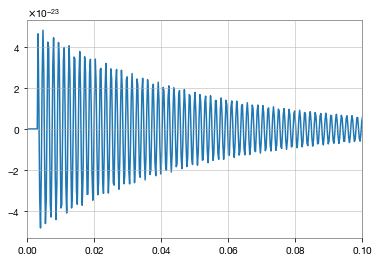

In [12]:
plt.plot(times, wave)
plt.xlim(0,0.1)

In [13]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time']-ts)

ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters)

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:35 bilby INFO    : Injected signal in H1:
12:35 bilby INFO    :   optimal SNR = 1.23
12:35 bilby INFO    :   matched filter SNR = 2.15-0.01j
12:35 bilby INFO    :   frac_dw = 0.8525351475285372
12:35 bilby INFO    :   frac_dtau = 15.158574630637228
12:35 bilby INFO    :   dphi = 0
12:35 bilby INFO    :   A = 5e-23
12:35 bilby INFO    :   w = 2167.876329689978
12:35 bilby INFO    :   t0 = 0
12:35 bilby INFO    :   phi = 0
12:35 bilby INFO    :   tau = -0.003040841645301787
12:35 bilby INFO    :   geocent_time = 0
12:35 bilby INFO    :   ra = 0
12:35 bilby INFO    :   dec = 0
12:35 bilby INFO    :   psi = 0
12:35 bilby INFO    :   ts = 0.0031280736927757286
12:35 bilby INFO    : Injected signal in L1:
12:35 bilby INFO    :   optim

[{'plus': array([1.65193815e-27+0.00000000e+00j,
         1.65140118e-27-4.61418376e-29j,
         1.64978999e-27-9.22702992e-29j, ...,
         6.85108397e-27+5.36425087e-28j,
         6.86679871e-27+2.68417001e-28j,
         6.87203961e-27+0.00000000e+00j]),
  'cross': array([ 1.28658118e-26+0.00000000e+00j,
          1.28559029e-26-5.05628445e-28j,
          1.28261912e-26-1.01048285e-27j, ...,
         -8.34853343e-28-7.10943213e-29j,
         -8.37103949e-28-3.55786328e-29j,
         -8.37854589e-28+0.00000000e+00j])},
 {'plus': array([1.65193815e-27+0.00000000e+00j,
         1.65140118e-27-4.61418376e-29j,
         1.64978999e-27-9.22702992e-29j, ...,
         6.85108397e-27+5.36425087e-28j,
         6.86679871e-27+2.68417001e-28j,
         6.87203961e-27+0.00000000e+00j]),
  'cross': array([ 1.28658118e-26+0.00000000e+00j,
          1.28559029e-26-5.05628445e-28j,
          1.28261912e-26-1.01048285e-27j, ...,
         -8.34853343e-28-7.10943213e-29j,
         -8.37103949e-28-3.

In [14]:
#create priors
prior = injection_parameters.copy()

#prior['tau'] = bilby.core.prior.Uniform(-0.1, -0.0001, r'damping time', unit='$s$')
prior['frac_dtau'] = bilby.core.prior.Uniform(1, 50, r'fraction damping time')

#prior['w'] = bilby.core.prior.Uniform(0, 3000, r'omega', unit='$rad/sec$')
prior['frac_dw'] = bilby.core.prior.Uniform(0.1, 1, r'fraction omega')

#prior['ts'] = bilby.core.prior.LogUniformUniform(0.005, 0.01, r'start time')

In [15]:
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform)

In [17]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=prior, sampler='dynesty', npoints=100, walks=10, nact=5,
    injection_parameters=injection_parameters, outdir=outdir, label=label, resume=False)

12:39 bilby INFO    : Running for label 'shift_220_M50_frac', output will be saved to 'outdir'
12:39 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
12:39 bilby INFO    : Search parameters:
12:39 bilby INFO    :   frac_dw = Uniform(minimum=0.1, maximum=1, name='fraction omega', latex_label='fraction omega', unit=None, boundary=None)
12:39 bilby INFO    :   frac_dtau = Uniform(minimum=1, maximum=50, name='fraction damping time', latex_label='fraction damping time', unit=None, boundary=None)
12:39 bilby INFO    :   dphi = 0
12:39 bilby INFO    :   A = 5e-23
12:39 bilby INFO    :   w = 2167.876329689978
12:39 bilby INFO    :   t0 = 0
12:39 bilby INFO    :   phi = 0
12:39 bilby INFO    :   tau = -0.003040841645301787
12:39 bilby INFO    :   geocent_time = 0
12:39 bilby INFO    :   ra = 0
12:39 bilby INFO    :   dec = 0
12:39 b


0it [00:00, ?it/s]

12:39 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12691aed0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:39 bilby INFO    : Checkpoint every n_check_point = 400000
12:39 bilby INFO    : Using dynesty version 1.0.1
12:39 bilby INFO    : Using the bilby-implemented rwalk sample met


1it [00:00,  3.77it/s, bound:0 nc:1 ncall:101 eff:1.0% logz-ratio=-17.99+/-0.33 dlogz:inf>0.10]
45it [00:00,  5.37it/s, bound:0 nc:2 ncall:166 eff:27.1% logz-ratio=-7.13+/-0.18 dlogz:8.300>0.10]
92it [00:00,  7.63it/s, bound:0 nc:3 ncall:240 eff:38.3% logz-ratio=-4.89+/-0.16 dlogz:6.079>0.10]
120it [00:00, 10.76it/s, bound:0 nc:5 ncall:312 eff:38.5% logz-ratio=-3.92+/-0.16 dlogz:4.943>0.10]
144it [00:00, 14.99it/s, bound:0 nc:1 ncall:401 eff:35.9% logz-ratio=-3.30+/-0.16 dlogz:4.085>0.10]
167it [00:00, 20.71it/s, bound:0 nc:2 ncall:490 eff:34.1% logz-ratio=-2.83+/-0.16 dlogz:3.401>0.10]
189it [00:01, 27.65it/s, bound:0 nc:3 ncall:612 eff:30.9% logz-ratio=-2.49+/-0.16 dlogz:2.864>0.10]
208it [00:01, 36.33it/s, bound:0 nc:6 ncall:701 eff:29.7% logz-ratio=-2.27+/-0.16 dlogz:2.481>0.10]
226it [00:01, 42.56it/s, bound:0 nc:17 ncall:893 eff:25.3% logz-ratio=-2.10+/-0.16 dlogz:2.164>0.10]
241it [00:01, 51.56it/s, bound:0 nc:2 ncall:1020 eff:23.6% logz-ratio=-1.98+/-0.15 dlogz:1.930>0.10]
254

494it [00:11, 15.15it/s, bound:53 nc:39 ncall:8877 eff:5.6% logz-ratio=-1.19+/-0.16 dlogz:0.226>0.10]
496it [00:11, 15.48it/s, bound:54 nc:49 ncall:8970 eff:5.5% logz-ratio=-1.19+/-0.16 dlogz:0.221>0.10]
498it [00:11, 15.19it/s, bound:55 nc:51 ncall:9064 eff:5.5% logz-ratio=-1.19+/-0.16 dlogz:0.217>0.10]
500it [00:12, 14.93it/s, bound:56 nc:47 ncall:9156 eff:5.5% logz-ratio=-1.19+/-0.16 dlogz:0.213>0.10]
502it [00:12, 14.46it/s, bound:57 nc:47 ncall:9252 eff:5.4% logz-ratio=-1.18+/-0.16 dlogz:0.209>0.10]
504it [00:12, 12.88it/s, bound:58 nc:50 ncall:9347 eff:5.4% logz-ratio=-1.18+/-0.16 dlogz:0.205>0.10]
506it [00:12, 13.00it/s, bound:59 nc:46 ncall:9437 eff:5.4% logz-ratio=-1.18+/-0.16 dlogz:0.201>0.10]
508it [00:12, 13.42it/s, bound:60 nc:42 ncall:9525 eff:5.3% logz-ratio=-1.18+/-0.16 dlogz:0.197>0.10]
510it [00:12, 14.04it/s, bound:61 nc:42 ncall:9610 eff:5.3% logz-ratio=-1.18+/-0.16 dlogz:0.193>0.10]
18196it [04:00, 17.01it/s, bound:5 nc:42 ncall:191767 eff:9.5% logz-ratio=-1.27+/-

12:39 bilby INFO    : Writing checkpoint file outdir/shift_220_M50_frac_resume.pickle



575it [00:17, 33.25it/s, bound:94 nc:1 ncall:12416 eff:5.4% logz-ratio=-1.05+/-0.18 dlogz:0.001>0.10] 

12:39 bilby INFO    : Sampling time: 0:00:16.724873
12:39 bilby INFO    : Summary of results:
nsamples: 675
log_noise_evidence: -3941.816
log_evidence: -3942.863 +/-  0.184
log_bayes_factor: -1.047 +/-  0.184



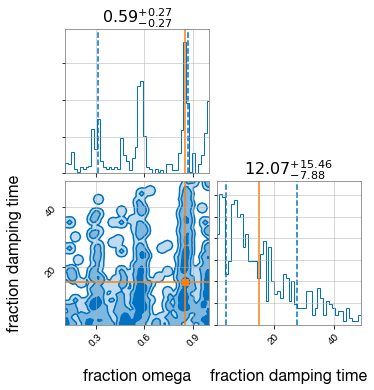

In [20]:
result.plot_corner(save=True)